# Graph and geometric learning

In this notebook your task is to prepare data for geometric learning. First we will look at converting images to graphs. Then we will look at getting graphs from 3D data. 

# MNIST super pixels

In [5]:
%cd /content/drive/MyDrive/GCN/

/content/drive/MyDrive/GCN


In [6]:
#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import color, segmentation
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
from skimage.measure import regionprops
from skimage.future import graph
import networkx as nx
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

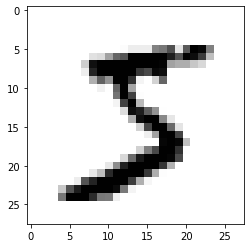

In [4]:
#get first image data and label and plot it
plt.imshow(x_train[0,:,:], cmap='gray_r');

In [5]:
# write a function that preprocesses the image to have 3 channels in the output. This is required for the segmentation 
def _preprocess(image): #make image have 3 channels
    if len(image.shape) == 2 or image.shape[2] == 1:
        return color.gray2rgb(
            np.reshape(image, (image.shape[0], image.shape[1])))
    else:
        return image

In [6]:
# write a function that takes the image, preprocesses it using the previous function anad then uses slic to obtain the segmentation
def get_slic(image, n_segments, compactness):
  processed_image = _preprocess(image)
  output = slic(processed_image, n_segments=50, compactness=10) #get segmentation 
  return output

processed_image = _preprocess(x_train[0,:,:])
segs = get_slic(x_train[0,:,:], n_segments=50, compactness=10)

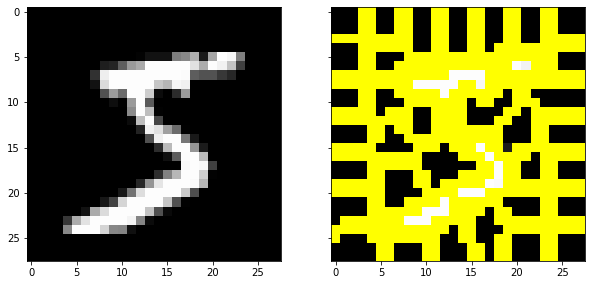

In [7]:
# plot the processsed image and the 
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(processed_image);
ax[1].imshow(mark_boundaries(processed_image, segs));

It looks a bit weird because the size of the image is soo tiny. We can scale up the image to get a better look at the segmentation

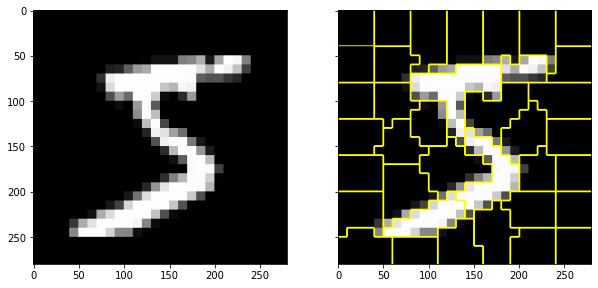

In [8]:
def scale_image(image, scale):
  image = np.repeat(image, scale, axis=0)
  image = np.repeat(image, scale, axis=1)
  return(image)

scale = 10 
scaled_im = scale_image(processed_image, scale)
scaled_seg = scale_image(segs,scale)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(scaled_im);
ax[1].imshow(mark_boundaries(scaled_im, scaled_seg));

Next we want to convert these segments to graphical nodes. 

In [12]:
g = graph.rag_mean_color(processed_image, segs) # Compute the graph from the segmentation using mean colors. This can be done using the function rag_mean_colour in graph

In [25]:
print('Nodes: \n', g.nodes) #print nodes
print('Degrees: \n', g.degree) #print number of degrees of each node (connections)
print('Edges: \n', g.edges) # print the connections
print('Node 0: \n', g.nodes[0]) #print the properties of the nodes

Nodes: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
Degrees: 
 [(0, 3), (1, 4), (2, 4), (3, 3), (4, 4), (5, 4), (6, 2), (7, 5), (8, 7), (9, 4), (10, 6), (11, 10), (12, 4), (13, 7), (14, 5), (15, 5), (16, 4), (17, 5), (18, 4), (19, 6), (20, 4), (21, 9), (22, 6), (23, 6), (24, 4), (25, 4), (26, 5), (27, 4), (28, 7), (29, 7), (30, 5), (31, 4), (32, 4), (33, 3), (34, 4), (35, 3), (36, 3)]
Edges: 
 [(0, 1), (0, 7), (0, 8), (1, 2), (1, 7), (1, 8), (2, 3), (2, 8), (2, 11), (3, 4), (3, 11), (4, 5), (4, 10), (4, 11), (5, 6), (5, 9), (5, 10), (6, 9), (7, 8), (7, 12), (7, 13), (8, 11), (8, 12), (8, 13), (9, 10), (9, 15), (10, 11), (10, 14), (10, 15), (11, 13), (11, 14), (11, 16), (11, 21), (11, 22), (12, 13), (12, 18), (13, 16), (13, 18), (13, 19), (14, 15), (14, 17), (14, 21), (15, 17), (15, 20), (16, 19), (16, 22), (17, 20), (17, 21), (17, 23), (18, 19), (18, 24), (19, 24), (19, 22), (19, 26), (20, 2

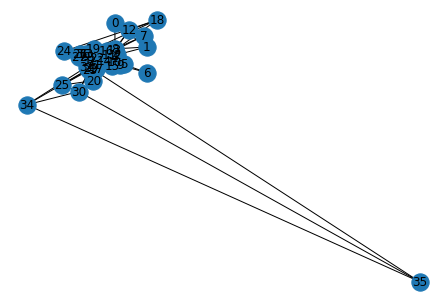

In [21]:
#draw the graph
nx.draw(g, with_labels=True)

In [ ]:
A = nx.to_numpy_matrix(g) #get adjacency matrix
print('shape: ', np.shape(A));
plt.imshow(A);

# 3D objects
3D data is hard to come by. Here we use ModelNet 3D objects. To use them, we need to represent them as cloud point data and assume points are nodes in a graph. The cloud point data are obtained by sampling the surface of the 3D objects.

In [7]:
import os
import glob
!pip install trimesh
import trimesh
!pip install git+https://github.com/tkipf/gcn.git

  Cloning https://github.com/tkipf/gcn.git to /tmp/pip-req-build-h54rrg3o
  Running command git clone -q https://github.com/tkipf/gcn.git /tmp/pip-req-build-h54rrg3o
  Created wheel for gcn: filename=gcn-1.0-cp37-none-any.whl size=9930 sha256=bbc821019b1e5e3294750f59153aff6041b38c6b28b3afb630083a87c732b224
  Stored in directory: /tmp/pip-ephem-wheel-cache-4v6qyruz/wheels/4c/af/71/38d80acca71d346aa56b6a906b150007735aa74e9845a3dc37
Successfully built gcn


In [8]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [9]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

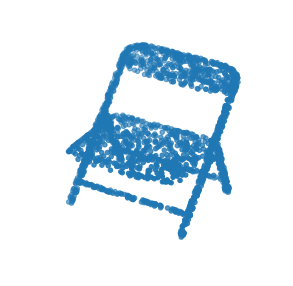

In [10]:
# Convert mesh to point cloud via sampling 
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [11]:
# parse through folders of ModelNet to get dataset
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [12]:
npoints = 100 #number of points to sample
nclasses = 10  #number of classes/labels

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(npoints)

processing class: sofa
processing class: night_stand
processing class: desk
processing class: dresser
processing class: toilet
processing class: chair
processing class: table
processing class: monitor
processing class: bed
processing class: bathtub


In [13]:
print('train size:', train_points.shape) # we have 3991 sets of training data each with 1000 points with x,y,z location coordinates
print('test size:', test_points.shape) # we have 908 sets of test data each with 1000 points with x,y,z location coordinates

train size: (3991, 100, 3)
test size: (908, 100, 3)


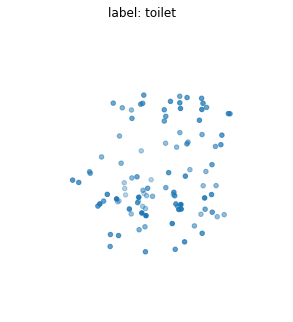

In [14]:
i = 1500 #plot the 1500th training sample

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(train_points[i, :, 0], train_points[i, :, 1], train_points[i, :, 2])
ax.set_axis_off()
fig.suptitle('label: '+CLASS_MAP[train_labels[i]]) #title is the label
plt.show()

We need to make a graph from the point cloud data. This can be done with help from k-nearest neighbours agorithm to find points that live close together in space.

In [38]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [16]:
# this function converts point cloud data into a graph
def pc2graph(pc, knn, threshold):
  G = nx.Graph() # initialise networkx graph
  N = pc.shape[0] #number of nodes 
  ix = np.arange(N, dtype=int) #array with the number of each node

  nn = NearestNeighbors(n_neighbors=knn, metric='euclidean',
                              leaf_size=15, n_jobs=-1).fit(pc)
  distances, indices = nn.kneighbors(pc) #returns the distances and indices of the k-nearest neihgbours for each node


  #make a list of pairs of nodes which are neighbours
  base = ix.repeat(knn).reshape([N, knn]) 
  edges = np.stack([base, indices, distances], axis=0).reshape([3,-1]).T # array that stores the pairs and the distances between them

  # add nodes
  G.add_nodes_from([(i, {'pos': attr}) for (i, attr) in zip(ix, pc)])

  # add edges, weighted by the distances between the pairs
  for j in np.arange(edges.shape[0]):
    if edges[j,2] <= threshold:
      G.add_weighted_edges_from([(edges[j,0], edges[j,1], edges[j,2])])
  return G

pc = train_points[0,:,:] # point cloud data
knn = 8 #number of neighbours
threshold = 20 # minimum distance of nodes to be a neighbour
G = pc2graph(pc, knn, threshold)

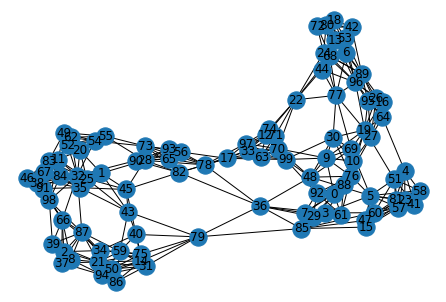

In [17]:
nx.draw(G, with_labels=True) #This graph looks really messy because the huge number of nodes. It may be useful to look at the graph made with less points, this can by done by editing pc

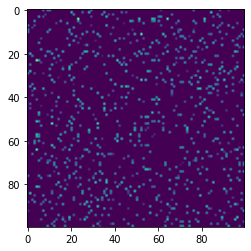

In [18]:
A = nx.to_numpy_matrix(G) #get adjacency matrix
plt.imshow(A);

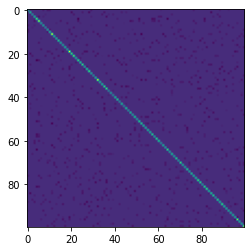

In [19]:
# Get laplacian - remember the Laplacian = D - A 
L = nx.laplacian_matrix(G) 
plt.imshow(L.toarray());

Now we train on the data. BEWARE 1000 points is huge! You may want to reduce the number of nodes using pooling. 

In order to do classification we need to make an adjacency matrix from all the graphs. This is going to be huge - for 100 nodes and 100 training objects, that's a 10000x10000 matrix!! So let's just use 100 training objects from 2 classes - toilet and bed, 50 from each

In [20]:
CLASS_MAP #list the objects

{0: 'sofa',
 1: 'night_stand',
 2: 'desk',
 3: 'dresser',
 4: 'toilet',
 5: 'chair',
 6: 'table',
 7: 'monitor',
 8: 'bed',
 9: 'bathtub'}

The adjacency matrix is a matrix of all the individual graph adjacency matrices stacked along the diagonal.



In [150]:
def make_adj(npoints, train_labels, ndata, classes, knn, threshold):  
  # npoints: number of nodes in each graph
  # train_labels: training labels from the graphs
  # ndata: number of data samples in each class
  # classes: array of classs indices

  nclasses = np.size(classes)
  adj_sz = npoints*ndata*nclasses
  A = np.zeros([adj_sz, adj_sz])
  
  labels = []
  ind = []
  for c in classes: #get the indices and labels
    labels = np.append(labels, np.repeat(c, ndata))
    ind = np.append(ind, np.where(train_labels == c)[0][0:ndata])
  
  #shuffle the 
  shuff = np.random.permutation(ndata*nclasses)
  sortlabels = labels[shuff].astype(int)
  sortind = ind[shuff].astype(int)

  idx = 0 # We need to loop over the matrix location 
  for ix in np.arange(ndata*nclasses): 
    pc = train_points[sortind[ix], :, :] 
    G = pc2graph(pc, knn, threshold)
    A[idx:(idx+npoints),idx:(idx+npoints)] = nx.to_numpy_matrix(G)
    idx = idx + npoints 
  return(A, sortlabels)


In [ ]:
# make and plot the adjacency matrix
A, y = make_adj(npoints = npoints, train_labels=train_labels, ndata = 50, classes=[4,8], knn=8, threshold=20)
plt.imshow(A);

In [30]:
A.shape

(10000, 10000)

In [106]:
from gcn.utils import *
from gcn.models import GCN, MLP

from __future__ import division
from __future__ import print_function
import time

In [44]:
import scipy.sparse as sp

In [118]:
adj = csr_matrix(A) #convert adjacency matrix to compressed sparse row format

In [117]:
# make a N x f, feature matrix where N is number of nodes and f is number of features. We fill this with values of 1.
adj_size = npoints*50*2
features = np.eye(adj_size)

In [119]:
features = sp.lil_matrix(features) 

In [138]:
# make a binary label matrix, this is N x number of classes
labels = np.eye(2)[(np.repeat(y, npoints)==8)*1]

In [146]:
# use first 80 for training, 10 for validation, 10 for test
train_mask = np.array(np.repeat(False,100))
train_mask[0:79] = True
train_mask = np.repeat(train_mask, npoints)
val_mask = np.array(np.repeat(False,100))
val_mask[79:89] = True
val_mask = np.repeat(val_mask, npoints)
test_mask = np.array(np.repeat(False,100))
test_mask[89:99] = True
test_mask = np.repeat(test_mask, npoints)
y_train = labels
y_val = labels
y_test = labels

In [122]:
features = preprocess_features(features)
support = [preprocess_adj(adj)]
num_supports = 1

The following is taken from GCN public code - https://github.com/tkipf/gc

In [132]:
from gcn.layers import *
from gcn.metrics import *

class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1])
            self.activations.append(hidden)
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def save(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, "tmp/%s.ckpt" % self.name)
        print("Model saved in file: %s" % save_path)

    def load(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = "tmp/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)


class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += 5e-4 * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=16,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=16,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


In [149]:
# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = GCN(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

cost_val = []

# Train model
for epoch in range(200):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Epoch: 0001 train_loss= 0.70163 train_acc= 0.47494 val_loss= 0.69715 val_acc= 0.53600 time= 0.19699
Epoch: 0002 train_loss= 0.69020 train_acc= 0.92810 val_loss= 0.69780 val_acc= 0.51000 time= 0.04040
Epoch: 0003 train_loss= 0.68156 train_acc= 0.98088 val_loss= 0.70013 val_acc= 0.53800 time= 0.03625
Epoch: 0004 train_loss= 0.67473 train_acc= 0.98177 val_loss= 0.70325 val_acc= 0.53600 time= 0.03398
Epoch: 0005 train_loss= 0.66731 train_acc= 0.98746 val_loss= 0.70672 val_acc= 0.53100 time= 0.03406
Epoch: 0006 train_loss= 0.66028 train_acc= 0.98822 val_loss= 0.71045 val_acc= 0.51800 time= 0.03688
Epoch: 0007 train_loss= 0.65302 train_acc= 0.98911 val_loss= 0.71446 val_acc= 0.48900 time= 0.03389
Epoch: 0008 train_loss= 0.64548 train_acc= 0.98923 val_loss= 0.71876 val_acc= 0.51000 time= 0.04018
Epoch: 0009 train_loss= 0.63896 train_acc= 0.99088 val_loss= 0.72333 val_acc= 0.54700 time= 0.03333
Epoch: 0010 train_loss= 0.63310 train_acc= 0.98898 val_loss= 0.72809 val_acc= 0.50800 time= 0.03733
